In [1]:
### Prepare module structure ###

import sys
sys.path.append('../')

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


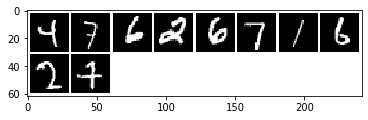

torch.Size([10, 1, 28, 28])


In [17]:
### LOAD DATA ###
dataset = 'mnist'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=10)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [10]:
### LOAD MODEL ###

latent_dim = 20
hidden_dim = 500

vae = models.SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=hidden_dim)
vae.load_state_dict(torch.load("/home/shared/phase-retrieval/models/VAE_MNIST/FC-VAE20Mnist_2.sd",
                              map_location={'cuda:0': device.__str__()}));

Version 4


In [11]:
### Hand Paper (adapted) ###

def calc_meas(x):
    m = A.shape[1]
    N = x.shape[0]
    C = x.shape[1]
    compressed = (x.view(N, C, -1) @ A).view(N, C, m)
    return torch.abs(compressed)

def vaeopt(sample_magnitudes, vae, device, measurement_fn=calc_meas,
           z_shape=(20, 1, 1), init_x=None, optim_lr=1e-1, max_steps=5000, max_loss=0.0):
    
    vae.to(device)
    vae.eval()
    
    N = sample_magnitudes.shape[0]
    
    if init_x is None:
        z = torch.randn((N, *z_shape), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x)[0].clone().detach().requires_grad_(True)
        
    optimizer = optim.Adam([z], lr=optim_lr)
    
    losses = []
    last_out = vae.decoder(z)
    
    for i in range(max_steps):
 
        magnitudes = measurement_fn(last_out)
        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=tuple(np.arange(len(magnitudes.shape))[1:]))
        loss = torch.sum(mse_all)
        
        if loss < max_loss:
            break
   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = vae.decoder(z)

        losses.append(loss.detach().cpu().item())
        
    return last_out.detach(), losses, mse_all

In [21]:
m = 50 # 25, 50, 100, 200, 300, 500, 784

import pickle

#A = (torch.randn(imsize[1] * imsize[2], m) / m).to(device)
#pickle.dump(A, open("../cache/A/A{}.p".format(m), "wb"))

A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)

print(A.shape)

torch.Size([784, 50])


Batch 1/1 finished


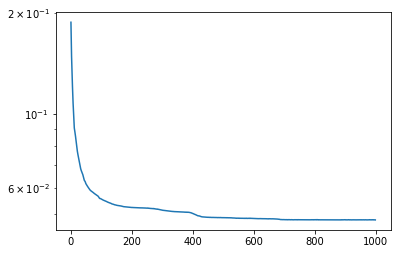

In [34]:
### Test one sample A measurements ###

num_batches = 1
batch_size = 10
max_steps = 1000
max_loss = 0.0
optim_lr= 1e-1
restarts = 10

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)


for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_measurements = calc_meas(test_sample)
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    for r in range(restarts):
        cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=test_measurements, vae=vae, device=device,
                                                        measurement_fn=calc_meas, z_shape=(latent_dim, ),
                                                        optim_lr=optim_lr, max_steps=max_steps, max_loss=max_loss)
        cur_out_results = cur_out_results.cpu().numpy()
        
        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [15]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_MNIST/Ameas10_original_2_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_MNIST/Ameas10_2_1024.p", "wb"))

In [16]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/Ameas10_original_2_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/Ameas10_2_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


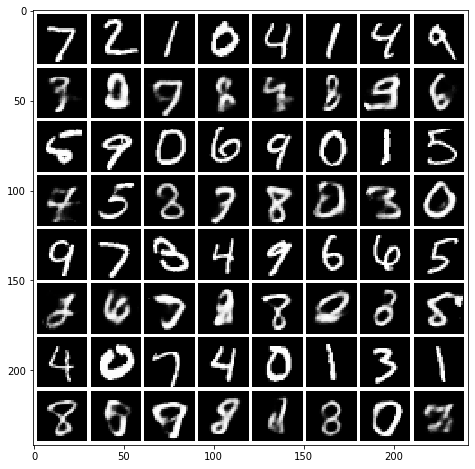

Signal error:
  MSE: 0.11353142397992749, std: 0.031233782412331518
  MAE: 0.1560977883824453, std: 0.034347826484150835
  SSIM: 0.2303134045854805, std: 0.11863522664249829
  FASI-MSE: 0.10482852939313039, std: 0.03280194335060228
  FASI-MAE: 0.1467905344684512, std: 0.03636844659766063
  COCO-MSE: 0.08935994364664142, std: 0.02528515856246703

Magnitude error:
  MSE Magnitude: 31.395284324818853, std: 12.381652368861163

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [17]:
print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8, 28, 28), 
                    out_results[:32].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
           
plot_grid(to_plot, figsize=(8, 8), file="../out/vae/mnist/{0}{1}.png".format('Ameas10_2_1024_', time.strftime("%Y%m%d_%H%M%S")))
#plot_grid(to_plot, figsize=(8, 8))

In [36]:
benchmark(pred=out_results, true=out_original, check_all=True)

Signal error:
  MSE: 0.04366177406688757, std: 0.038696978091379376
  MAE: 0.0766509784847133, std: 0.052606668426867724
  SSIM: 0.662533295811494, std: 0.25420009636813656
  Sharpness: 0.11456394799842558, std: 0.0611390200569004
  PhCo-MSE: 0.07533968826271684, std: 0.08628910914321047
  PhCo-MAE: 0.11029134637385532, std: 0.10010783753258978
  PhCo-SSIM: 0.5681072846512356, std: 0.3587421082467338
  CroCo-MSE: 0.041602680400245014, std: 0.03753745184811144
  CroCo-MAE: 0.07417897701263643, std: 0.05115667511517169
  CroCo-SSIM: 0.6765519256452457, std: 0.24743247489060374

Magnitude error:
  MSE Magnitude: 11.411549989231421, std: 9.352781800438981

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.04366 | 0.07665 | 0.6625 | 0.1146 | 0.07534 | 0.1103 | 0.5681 | 0.04160 | 0.07418 | 0.6766 | 11.41 |


## Test A measurements random init (1024 samples)

lr checked for what works best on 1 batch

| Nr Type | iterations | restarts | lr | m | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 2 | 10000 | 3 | 1e-1 | 784 | 0.004868 | 0.02290 | 0.9489 | 0.004906 | 0.02295 | 0.004863 | 1.937 |
| 2 | 10000 | 3 | 1e-1 | 500 | 0.005173 | 0.02340 | 0.9458 | 0.005214 | 0.02345 | 0.005153 | 2.037 |
| 2 | 10000 | 3 | 1e-1 | 300 | 0.008464 | 0.02776 | 0.9182 | 0.008403 | 0.02771 | 0.007937 | 2.886 |
| 2 | 10000 | 3 | 1e-1 | 200 | 0.01564 | 0.03701 | 0.8606 | 0.01596 | 0.03741 | 0.01449 | 4.821 |
| 2 | 10000 | 3 | 1e-1 | 100 | 0.03992 | 0.06878 | 0.6741 | 0.04080 | 0.06975 | 0.03583 | 11.22 |
| 2 | 10000 | 3 | 1e-1 | 50 | 0.07241 | 0.1090 | 0.4476 | 0.07435 | 0.1110 | 0.06236 | 19.31 |
| 2 | 10000 | 3 | 1e-1 | 25 | 0.1004 | 0.13878 | 0.3107 | 0.09986 | 0.1381 | 0.08371 | 26.10 |
| 2 | 10000 | 3 | 1e-1 | 10 | 0.1164 | 0.1527 | 0.2580 | 0.1112 | 0.1472 | 0.09411 | 30.099 |
| 2 | 10000 | 3 | 1e-1 | 0 | 0.1135 | 0.1561 | 0.2303 | 0.1048 | 0.1468 | 0.08936 | 31.39 |

## Test A measurements random init (10 samples)


| Nr Type | iterations | restarts | lr | m | MSE | MAE | SSIM |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 2 | 10000 | 5 | 1e-1 | 50 |  0.06695 | 0.1021 | 0.4986 |
| 2 | 1000 | 10 | 1e-1 | 50 | 0.04366 | 0.07665 | 0.6625 |


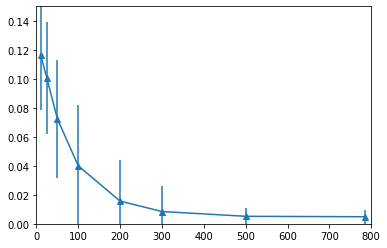

In [18]:
mse = [0.004867, 0.005173, 0.008463, 0.01564, 0.03992, 0.07241, 0.1004, 0.1165]
m = [784, 500, 300, 200, 100, 50, 25, 10]
std = [0.004694, 0.005842, 0.01773, 0.02817, 0.04204, 0.04059, 0.03873, 0.03794]

axes = plt.gca()
axes.set_xlim([0, 800])
axes.set_ylim([0, 0.15])
plt.errorbar(m, mse, std, marker='^')
plt.show()

### Raw outputs:

m=784:

Signal error:
  MSE: 0.004867586453620506, std: 0.004694949393071813
  MAE: 0.02289965629581409, std: 0.010952862035534333
  SSIM: 0.9488822423684341, std: 0.04722588146864507
  FASI-MSE: 0.004906189543105447, std: 0.0053646108229364695
  FASI-MAE: 0.0229459835051708, std: 0.011419513247268014
  COCO-MSE: 0.0048631002615555936, std: 0.004641734905393253

Magnitude error:
  MSE Magnitude: 1.9370875334562903, std: 1.6223327312309255


m=500:

Signal error:
  MSE: 0.005173815709279899, std: 0.005842832392618835
  MAE: 0.023399108290832936, std: 0.012318621206219633
  SSIM: 0.94582601112062, std: 0.05799499144949138
  FASI-MSE: 0.005214369365255133, std: 0.0062091802667873265
  FASI-MAE: 0.023448101831928886, std: 0.012637479751949269
  COCO-MSE: 0.005152766103555335, std: 0.005609049913945585

Magnitude error:
  MSE Magnitude: 2.037961093062209, std: 1.9890685653855016


m=300:

Signal error:
  MSE: 0.008463605682660802, std: 0.017731802714780795
  MAE: 0.027763933169428642, std: 0.024368611278947627
  SSIM: 0.9182234822551578, std: 0.1400489496299788
  FASI-MSE: 0.00840348482154082, std: 0.017214401138884127
  FASI-MAE: 0.027714577030828594, std: 0.02393978106198022
  COCO-MSE: 0.007937457294153936, std: 0.014635789032079807

Magnitude error:
  MSE Magnitude: 2.8860125433604633, std: 4.42504652490602

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


m=200:

Signal error:
  MSE: 0.01564182045189706, std: 0.028178433038176263
  MAE: 0.037009493421559694, std: 0.036949250732262046
  SSIM: 0.8605807462205224, std: 0.21623219385475984
  FASI-MSE: 0.015958637162885578, std: 0.02900610420737281
  FASI-MAE: 0.03740745833339535, std: 0.03809787739804666
  COCO-MSE: 0.014491643593808164, std: 0.024829579903736767

Magnitude error:
  MSE Magnitude: 4.820822520670815, std: 7.485833743481511


m=100:

Signal error:
  MSE: 0.0399187281967633, std: 0.04204587368752897
  MAE: 0.06877082396625585, std: 0.05258951902842954
  SSIM: 0.6741111704748709, std: 0.2905061590005729
  FASI-MSE: 0.04079578508084761, std: 0.042241328736677415
  FASI-MAE: 0.06975297516449966, std: 0.05310910734950914
  COCO-MSE: 0.03583008687276413, std: 0.03574370426927193

Magnitude error:
  MSE Magnitude: 11.21535315686895, std: 10.735382944726116


m=50:

Signal error:
  MSE: 0.0724055045263752, std: 0.04059079643963494
  MAE: 0.10895643126877401, std: 0.04623282538082707
  SSIM: 0.4475976422216453, std: 0.23689426586341722
  FASI-MSE: 0.07434697570288043, std: 0.04183367316511802
  FASI-MAE: 0.11099025607218097, std: 0.04771276428432791
  COCO-MSE: 0.06235973210959271, std: 0.032357643993114624

Magnitude error:
  MSE Magnitude: 19.312419639785706, std: 10.18353815864352


m=25:

Signal error:
  MSE: 0.10043600748676557, std: 0.03873204073599404
  MAE: 0.13877861299172004, std: 0.040827240987581656
  SSIM: 0.310729238340512, std: 0.1751272492140091
  FASI-MSE: 0.09986208847650632, std: 0.03984975460766077
  FASI-MAE: 0.138116513148046, std: 0.04257102700307723
  COCO-MSE: 0.08371095624772705, std: 0.030043478774041777

Magnitude error:
  MSE Magnitude: 26.100611518200953, std: 10.257426376818193
  

m=10:

Signal error:
  MSE: 0.1164539288925064, std: 0.037949125852737256
  MAE: 0.15270692806062414, std: 0.040388893643707624
  SSIM: 0.25799861568455107, std: 0.13934700835676947
  FASI-MSE: 0.11119309286131787, std: 0.039081064561679195
  FASI-MAE: 0.14715339355555035, std: 0.041937919720239254
  COCO-MSE: 0.09411475219059151, std: 0.02988361385447494

Magnitude error:
  MSE Magnitude: 30.09949258958082, std: 11.777448080610938


m=0:


Signal error:
  MSE: 0.11353142397992749, std: 0.031233782412331518
  MAE: 0.1560977883824453, std: 0.034347826484150835
  SSIM: 0.2303134045854805, std: 0.11863522664249829
  FASI-MSE: 0.10482852939313039, std: 0.03280194335060228
  FASI-MAE: 0.1467905344684512, std: 0.03636844659766063
  COCO-MSE: 0.08935994364664142, std: 0.02528515856246703

Magnitude error:
  MSE Magnitude: 31.395284324818853, std: 12.381652368861163
